<a href="https://colab.research.google.com/github/2024S-Ajou-ML-pandastic4/whaccent/blob/master/whisper_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from typing import List
import io
import os
import pandas as pd
import urllib.request
import tarfile
import time
import http
import types
from torch.utils.data import Dataset, DataLoader
from transformers import WhisperFeatureExtractor
import torch
import torchaudio
import random
from tqdm import tqdm
import datetime
import seaborn as sns
from seaborn.widgets import plt
from datasets import load_dataset, DatasetDict, Audio
from torch.nn.utils.rnn import pad_sequence
from numpy.ma.core import diag

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
COUNTRY_MAP = {
    "KR": 0,
    "US": 1,
    "GB": 2,
}
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 100
PATIENCE = 15
CHECKPOINT_DIRECTORY = '/content/drive/MyDrive/checkpoints_5'

In [ ]:
dataset_name = "iisking/waccent"
dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validatoin") #
dataset["test"] = load_dataset(dataset_name, split="test")

# 오디오 데이터셋으로 변환
dataset = dataset.cast_column("filename", Audio(sampling_rate=16000))

# 라벨을 숫자로 변환하기 위한 맵핑
accent_to_label = {accent: idx for idx, accent in enumerate(set(dataset["train"]["accent"]))}

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, accent_to_label, max_length=16000 * 10): # 모든 데이터가 10초 보다 작음
        self.dataset = hf_dataset
        self.accent_to_label = accent_to_label
        self.max_length = max_length  # 최대 길이를 설정

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio = item["filename"]["array"]
        accent = item["accent"]

        # 오디오 데이터를 텐서로 변환
        audio = torch.tensor(audio)
        duration = len(audio) / 16000

        # 라벨을 숫자로 변환
        label = self.accent_to_label[accent]

        # 오디오 길이를 max_length로 패딩 또는 잘라내기
        if audio.shape[0] > self.max_length:
            audio = audio[:self.max_length]
        else:
            pad_size = self.max_length - audio.shape[0]
            audio = torch.nn.functional.pad(audio, (0, pad_size))

        return audio, label, duration

def collate_fn(batch):
    # 배치의 오디오와 라벨을 각각 분리
    audios, labels, durations = zip(*batch)
    # 오디오 시퀀스를 패딩하여 텐서로 변환
    audios = pad_sequence(audios, batch_first=True)
    labels = torch.tensor(labels)
    return audios, labels, durations

# 데이터셋 및 데이터로더 생성
train_dataset = CustomDataset(dataset["train"], accent_to_label)
val_dataset = CustomDataset(dataset["validation"], accent_to_label)
test_dataset = CustomDataset(dataset["test"], accent_to_label)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 데이터 로더 테스트
for audio, label, duration in train_loader:
    print(audio.shape, label, duration)
    break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating validatoin split:   0%|          | 0/3618 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1782 [00:00<?, ? examples/s]

torch.Size([32, 160000]) tensor([1, 2, 2, 3, 1, 2, 4, 4, 1, 1, 5, 1, 3, 1, 1, 5, 2, 0, 0, 4, 1, 1, 1, 0,
        1, 1, 3, 4, 5, 5, 2, 1]) (2.856, 5.784, 3.048, 7.776, 5.568, 2.616, 5.488, 6.2619375, 2.76, 3.096, 1.824, 3.504, 7.416, 3.144, 1.896, 6.024, 5.016, 2.592, 5.808, 5.210625, 3.504, 1.776, 3.648, 5.52, 1.944, 2.904, 2.16, 4.08, 2.112, 3.48, 4.584, 2.4)


In [ ]:
class Whaccent(torch.nn.Module):
    def __init__(self, hidden_size=80, num_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.backbone = WhisperFeatureExtractor.from_pretrained("openai/whisper-large-v2")
        self.lstm = torch.nn.LSTM(input_size=80, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=0.3, batch_first=True)
        self.classifier = torch.nn.Sequential(
            # torch.nn.Linear(self.hidden_size, 80),
            # torch.nn.ReLU(),
            # torch.nn.Linear(80, 6),
            # torch.nn.Softmax(dim=2)

            # torch.nn.Linear(self.hidden_size, 256),
            # torch.nn.ReLU(),
            # torch.nn.Linear(256, 256),
            # torch.nn.ReLU(),
            # torch.nn.Linear(256, 6),
            # torch.nn.Softmax(dim=2)

            torch.nn.Linear(self.hidden_size, 6),
            torch.nn.Softmax(dim=2)
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=DEVICE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=DEVICE)
        x = [sample.cpu().numpy() for sample in x]
        x = self.backbone(x, sampling_rate=16000, return_tensors='pt')
        x = x['input_features'].to(DEVICE)
        x = x.transpose(1, 2)
        x, _ = self.lstm(x, (h0, c0))
        x = self.classifier(x)
        return x

In [ ]:
def count_correct(predicted, target, duration):
    correct = 0
    for pred, targ, dura in zip(predicted, target, duration):
        correct_ = 0
        dura = round(dura * 100)
        pred = torch.argmax(pred[:dura], dim=1)
        targ = torch.argmax(targ[:dura], dim=1)
        correct += (pred == targ).sum().item() / dura
    return correct


def create_target(target_, predicted):
    return (
        torch.tensor(
            [
                [
                    [
                        0.9 if target_[index] == 0 else 0.02,
                        0.9 if target_[index] == 1 else 0.02,
                        0.9 if target_[index] == 2 else 0.02,
                        0.9 if target_[index] == 3 else 0.02,
                        0.9 if target_[index] == 4 else 0.02,
                        0.9 if target_[index] == 5 else 0.02,
                    ]
                ]
                * len(chunks)
                for index, chunks in enumerate(predicted)
            ]
        )
        .float()
        .to(DEVICE)
    )
    # return torch.tensor(target_)


def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = 0
    num_batches = len(dataloader)
    model.train()
    epoch_loss, epoch_correct = 0, 0

    for data, target_, duration in tqdm(dataloader, position=0, leave=True):
        size += len(data)

        optimizer.zero_grad()  # gradiant 초기화
        predicted = model(data)

        target = create_target(target_, predicted).to(DEVICE)
        loss = loss_fn(predicted, target)
        loss.backward()  # backword process
        optimizer.step()  # weight (&bias) update

        epoch_loss += loss.item()
        epoch_correct += count_correct(predicted, target, duration)

    train_acc = epoch_correct / size
    lr_scheduler.step()

    return train_acc, epoch_loss / num_batches


def test(dataloader, model, loss_fn):
    size = 0
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0

    with torch.no_grad():  # grad 연산 X
        model.eval()  # evaluation dropout 연산시
        for data_, target_, duration in tqdm(dataloader, position=0, leave=True):
            data = data_.to(DEVICE)
            size += len(data)

            predicted = model(data)
            target = create_target(target_, predicted)
            loss = loss_fn(predicted, target)

            epoch_loss += loss.item()
            epoch_correct += count_correct(predicted, target, duration)

    test_acc = epoch_correct / size

    return test_acc, epoch_loss / num_batches

In [ ]:
def save(directory_path, model, optimizer, loss, epoch):
    path = (
        f'{directory_path}/{datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")}_{loss}'
    )
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        path,
    )

In [ ]:
def run_train(model, checkpoint=None):
    init_epoch = 0
    # loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8)
    counter = 0
    best_acc = 0

    if checkpoint is not None:
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        init_epoch = checkpoint["epoch"]

    for epoch in tqdm(range(init_epoch, EPOCHS), position=0, leave=True):
        train_acc, train_loss = train(train_loader,
                                      model,
                                      loss_fn,
                                      optimizer,
                                      scheduler)

        val_acc , val_loss = test(val_loader, model, loss_fn)
        print(f'epoch:{epoch} \
        train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
        val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
        learning rate: {optimizer.param_groups[0]["lr"]}')

        if val_acc > best_acc:
            counter = 0
            best_acc = val_acc
            save(CHECKPOINT_DIRECTORY, model, optimizer, val_acc, epoch)
        else:
            counter+=1

        if counter >= PATIENCE:
            test_acc , val_loss = test(test_loader, model, loss_fn)
            print("Early stop !")
            print(test_acc)
            break
run_train(Whaccent().to(DEVICE), '/content/drive/MyDrive/checkpoints_5/20240601050322_0.5539251977001556')

  5%|▌         | 1/20 [05:05<1:36:48, 305.72s/it]

epoch:80         train_loss = 0.1508 , train_acc:0.1555         val_loss = 0.1159 , val_acc:0.2247         learning rate: 0.00011529215046068484


 10%|█         | 2/20 [10:10<1:31:32, 305.15s/it]

epoch:81         train_loss = 0.0990 , train_acc:0.2966         val_loss = 0.0946 , val_acc:0.3116         learning rate: 0.00011529215046068484


 15%|█▌        | 3/20 [15:15<1:26:27, 305.15s/it]

epoch:82         train_loss = 0.0856 , train_acc:0.3669         val_loss = 0.0850 , val_acc:0.3751         learning rate: 0.00011529215046068484


 15%|█▌        | 3/20 [20:16<1:54:52, 405.44s/it]


KeyboardInterrupt: 

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tensor(2)
tensor([[0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200],
        ...,
        [0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.9000, 0.0200, 0.0200, 0.0200]], device='cuda:0')


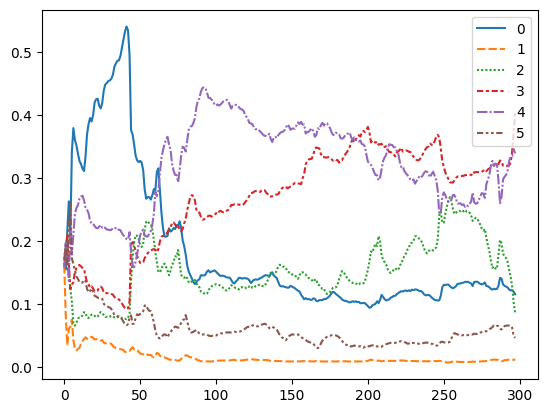

In [ ]:
def run_demo(model, checkpoint=None):
    if checkpoint is not None:
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint["model_state_dict"])

    with torch.no_grad():  # grad 연산 X
        model.eval()  # evaluation dropout 연산시
        for data_, target_, duration in test_loader:
            data = data_.to(DEVICE)

            print(target_[0])
            predicted = model(data)
            target = create_target(target_, predicted)
            data = predicted[0].cpu().numpy()
            duration = round(duration[0] * 100)
            data = data[:duration]
            print(target[0])

            sns.lineplot(data=data)
            # sns.lineplot(data=predicted[1])
            # sns.lineplot(data=predicted[2])
            # print(data)
            # print(predicted)
            break

run_demo(Whaccent().to(DEVICE),
         '/content/drive/MyDrive/checkpoints_5/20240601050322_0.5539251977001556')

In [ ]:
from sklearn.metrics import confusion_matrix

# y_true = []
# y_pred = []

def simplify_pred(predicted, duration):
    simplified = []
    for pred, dura in zip(predicted, duration):
        pred = torch.argmax(pred, dim=1)
        dura = round(dura * 100)
        pred = pred[:dura]
        pred = round(pred.sum().item() / dura)
        simplified.append(pred)
    return simplified


def create_confusion_matrix(model, checkpoint=None):
    # if checkpoint is not None:
    #     checkpoint = torch.load(checkpoint)
    #     model.load_state_dict(checkpoint["model_state_dict"])
    # with torch.no_grad():  # grad 연산 X
    #     model.eval()  # evaluation dropout 연산시
    #     for data_, target_, duration in tqdm(test_loader, position=0, leave=True):
    #         data = data_.to(DEVICE)

    #         predicted = model(data)
    #         y_pred.extend(simplify_pred(predicted, duration))
    #         y_true.extend(target_)

    print(y_true)
    print(y_pred)
    # y_true_ = []
    # y_pred_ = []
    # for t, p in zip(y_true, y_pred):
    #     y_true_.append([4, 5, 3, 2, 1, 0][t])
    #     y_pred_.append([4, 5, 3, 2, 1, 0][p])

    # cm = confusion_matrix(y_true_, y_pred_)
    # acc = sum(diag(cm)) / sum(sum(cm))
    # print(f'acc: {acc}')
    # # labels = ['indian', 'KR', 'canada', 'england', 'us', 'australia']
    # labels = ['australia', 'us', 'england', 'canada', 'indian', 'KR']
    # data = pd.DataFrame(cm, index=labels, columns=labels)
    # ax = sns.heatmap(data, annot=True, fmt="d", cmap=plt.cm.Blues)

create_confusion_matrix(Whaccent().to(DEVICE),
         '/content/drive/MyDrive/checkpoints_5/20240601050322_0.5539251977001556')

[tensor(2), tensor(0), tensor(5), tensor(1), tensor(0), tensor(1), tensor(5), tensor(4), tensor(5), tensor(3), tensor(0), tensor(2), tensor(4), tensor(5), tensor(1), tensor(1), tensor(5), tensor(3), tensor(4), tensor(3), tensor(1), tensor(1), tensor(2), tensor(3), tensor(3), tensor(3), tensor(4), tensor(3), tensor(3), tensor(0), tensor(0), tensor(1), tensor(2), tensor(2), tensor(4), tensor(3), tensor(4), tensor(2), tensor(4), tensor(2), tensor(2), tensor(0), tensor(4), tensor(0), tensor(4), tensor(4), tensor(4), tensor(2), tensor(3), tensor(2), tensor(2), tensor(3), tensor(2), tensor(2), tensor(4), tensor(4), tensor(4), tensor(3), tensor(4), tensor(4), tensor(5), tensor(5), tensor(4), tensor(5), tensor(3), tensor(2), tensor(5), tensor(3), tensor(5), tensor(4), tensor(5), tensor(2), tensor(1), tensor(5), tensor(1), tensor(0), tensor(3), tensor(1), tensor(4), tensor(3), tensor(4), tensor(4), tensor(0), tensor(1), tensor(0), tensor(4), tensor(3), tensor(4), tensor(5), tensor(0), tensor(3)

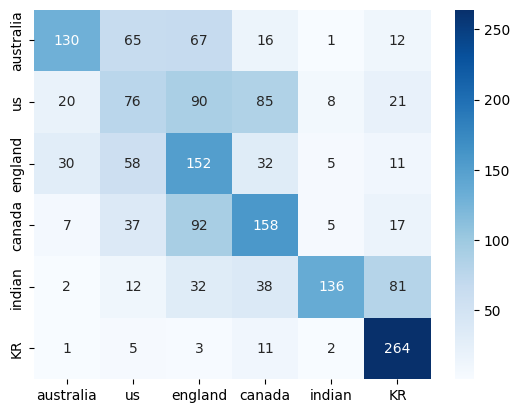

In [ ]:
labels = ['australia', 'us', 'england', 'canada', 'indian', 'KR']
data = pd.DataFrame([
    [130, 65, 67, 16, 1, 12],
    [20, 76, 90, 85, 8, 21],
    [30, 58, 152, 32, 5, 11],
    [7, 37, 92, 158, 5, 17],
    [2, 12, 32, 38, 136, 81],
    [1, 5, 3, 11, 2, 264],
], index=labels, columns=labels)
ax = sns.heatmap(data, annot=True, fmt="d", cmap=plt.cm.Blues)

In [ ]:
    [[130, 65, 67, 16, 1, 12],
    [20, 76, 90, 85, 8, 21],
    [30, 58, 152, 32, 5, 11],
    [7, 37, 92, 158, 5, 17],
    [2, 12, 32, 38, 136, 81],
    [1, 5, 3, 11, 2, 264],]